<a href="https://colab.research.google.com/github/gvozdila/kaggle-xray/blob/FastAI/MultiLabelClassification_FastAI__baseline_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#для kaggle https://colab.research.google.com/github/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb#scrollTo=d5fdlsGmCScc
#!pip install --user ../input/fastaimaster/torch-1.9.0-cp37-cp37m-manylinux1_x86_64.whl
!pip install -U fastai


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 31.9 MB/s 
     |████████████████████████████████| 61 kB 8.3 MB/s 
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.4.4
    Uninstalling fastcore-1.4.4:
      Successfully uninstalled fastcore-1.4.4
  Attempting uninstall: fastai
    Found existing installation: fastai 2.6.3
    Uninstalling fastai-2.6.3:
      Successfully uninstalled fastai-2.6.3


In [2]:
import fastcore
import fastai
print(f'fastcore version {fastcore.__version__} installed.')
print(f'fastai version {fastai.__version__} installed.')

fastcore version 1.4.5 installed.
fastai version 2.7.4 installed.


In [ ]:
#Когда будем юзать fastai2.medical.imaging , пока не используется
#!pip install pydicom kornia opencv-python scikit-image

In [ ]:
#!pip install --no-cache-dir -I pillow
#еще один костыль.Если  ругается,типа AttributeError: module 'PIL.Image' has no attribute 'Resampling',раскомментировать и выполнить один раз

In [3]:
from fastai import *
from fastai.vision.all import *
import numpy as np 
import pandas as pd 




In [4]:
#Лучше еще добавить
import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_csv = pd.read_csv ('/content/drive/MyDrive/train.csv')
#classes = list(train_csv.Target.unique())
train_path='/content/drive/MyDrive/train_xray'
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')[['SOPInstanceUID', 'Target']]
train_df['Target'] = train_df['Target'].apply(lambda x: x.strip())
test_df = pd.read_csv ('/content/drive/MyDrive/xr/xray/sample_submission.csv')







In [7]:
train_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,3
...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920578985719244800351,14
1734,1.2.826.0.1.3680043.8.498.99727280485333900933067489723088200708,11
1735,1.2.826.0.1.3680043.8.498.99935008698914755885142961280499046059,3
1736,1.2.826.0.1.3680043.8.498.99969671777553755311455387279891445345,2


In [8]:
train_df.Target.unique()

array(['0', '15', '12', '14', '3', '13 20', '5', '17', '2', '6', '9 21',
       '9', '16', '7', '11', '1', '20', '21', '13', '0 3', '8', '1 11 12',
       '0 15', '19', '10', '4', '11 12', '1 6', '10 19', '5 8', '3 15',
       '7 9', '15 19', '2 13 20', '18', '3 6', '2 20', '10 11 19', '1 12',
       '3 7', '8 16'], dtype=object)

In [9]:
print(train_df.dtypes)

SOPInstanceUID    object
Target            object
dtype: object


In [9]:
#Сделаем Target более читаемым.hip ,thigh в чем разница?
#"thigh - бедренная кость" ?
#"hip - мышца бедра", типа ляжка по нашему?


idx2lbl = {
"0":"Брюшная_полость",
"1":"Лодыжка",
"2":"Шейный_отдел",
"3":"Грудь",
"4":"Ключица",
"5":"Локоть",
"6":"Ноги",
"7":"Палец",
"8":"Предплечье",
"9":"Рука",
"10":"Мышца_бедра",
"11":"Колено",
"12":"Голень",
"13":"Поясничный_отдел",
"14":"Другое",
"15":"Таз",
"16":"Плечо",
"17":"Синус",
"18":"Череп",
"19":"Бедренная_кость",
"20":"Грудной_отдел",
"21":"Запястье",
"13 20":"Поясничный_отдел" "Грудной_отдел",
"9 21":"Рука" "Запястье",
"0 3":"Брюшная_полость" "Грудь",
"1 11 12":"Лодыжка" "Колено" "Голень",
"0 15":"Брюшная_полость" "Таз",
"11 12":"Колено" "Голень",
"1 6":"Лодыжка" "Ноги",
"10 19":"Мышца_бедра" "Бедренная_кость",
"5 8":"Локоть" "Предплечье",
"3 15":"Грудь" "Таз",
"7 9":"Палец" "Рука",
"15 19":"Плечо" "Бедренная_кость",
"2 13 20":"Шейный_отдел" "Поясничный_отдел" "Грудной_отдел",
"3 6":"Грудь" "Ноги",
"2 20":"Шейный_отдел" "Грудной_отдел",
"10 11 19":"мышца_бедра" "Колено" "Бедренная_кость",
"1 12":"Лодыжка" "Голень",
"3 7":"Грудь" "Палец",
"8 16":"Предплечье" "Плечо"

         }

train_df['Target'].replace(idx2lbl, inplace=True)
train_df



,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,Брюшная_полость
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,Таз
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,Голень
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,Другое
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,Грудь
...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920578985719244800351,Другое
1734,1.2.826.0.1.3680043.8.498.99727280485333900933067489723088200708,Колено
1735,1.2.826.0.1.3680043.8.498.99935008698914755885142961280499046059,Грудь
1736,1.2.826.0.1.3680043.8.498.99969671777553755311455387279891445345,Шейный_отдел


In [10]:
train_df.Target.unique()

array(['Брюшная_полость', 'Таз', 'Голень', 'Другое', 'Грудь',
       'Поясничный_отделГрудной_отдел', 'Локоть', 'Синус', 'Шейный_отдел',
       'Ноги', 'РукаЗапястье', 'Рука', 'Плечо', 'Палец', 'Колено',
       'Лодыжка', 'Грудной_отдел', 'Запястье', 'Поясничный_отдел',
       'Брюшная_полостьГрудь', 'Предплечье', 'ЛодыжкаКоленоГолень',
       'Брюшная_полостьТаз', 'Бедренная_кость', 'Мышца_бедра', 'Ключица',
       'КоленоГолень', 'ЛодыжкаНоги', 'Мышца_бедраБедренная_кость',
       'ЛокотьПредплечье', 'ГрудьТаз', 'ПалецРука',
       'ПлечоБедренная_кость',
       'Шейный_отделПоясничный_отделГрудной_отдел', 'Череп', 'ГрудьНоги',
       'Шейный_отделГрудной_отдел', 'мышца_бедраКоленоБедренная_кость',
       'ЛодыжкаГолень', 'ГрудьПалец', 'ПредплечьеПлечо'], dtype=object)

In [ ]:
#Создаем блок данных на основании шаблона
#dblock = DataBlock(get_x = get_images_name,
#                   get_y = get_target_name)

In [11]:
item_tfms = [Resize(128)]
batch_tfms=[*aug_transforms(flip_vert=True,max_zoom=1.2, max_warp=0,batch=True), Normalize.from_stats(*imagenet_stats)]

In [12]:
db = DataBlock (blocks=(ImageBlock, MultiCategoryBlock),  #используем блок данных для мультикатегорий
                   get_x=ColReader(0, #данные по именам изображений у нас хранятся в первом столбце, по логике датафрейма - в нулевом
                                   pref='/content/drive/MyDrive/train_xray/',
                                   suff='-c.bone.jpg'),
                  splitter = RandomSplitter(valid_pct=0.2),  #Сколько данных отложим для валидации.Здесь - 20 процентов
                  
                   get_y=ColReader(1,               #данные по меткам изображений у нас во втором столбце, по логике датафрейма - в первом. 
                                   label_delim=' '  #в случае, если на картинке больше одной метки, они разделены пробелом
                                   ) 

                )                                             
                              
                                  
                   
                
                 

In [13]:
item_tfms = item_tfms,
batch_tfms=batch_tfms

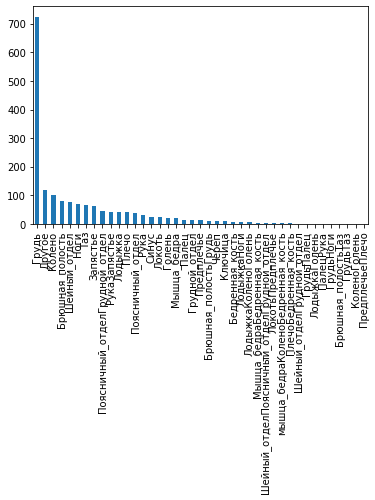

In [44]:
train_df['Target'].value_counts().plot.bar()

In [45]:
#print(train_df.groupby(['Target']).size())

In [14]:
train_df['Target'].value_counts()

Грудь                                        724
Другое                                       120
Колено                                       102
Брюшная_полость                               80
Шейный_отдел                                  77
Ноги                                          70
Таз                                           67
Запястье                                      63
Поясничный_отделГрудной_отдел                 45
РукаЗапястье                                  42
Лодыжка                                       41
Плечо                                         40
Поясничный_отдел                              39
Рука                                          31
Синус                                         23
Локоть                                        23
Голень                                        19
Мышца_бедра                                   19
Палец                                         15
Грудной_отдел                                 15
Предплечье          

In [15]:
bs=2 #размер батча.Если делать больше, то в коллабе out of memore

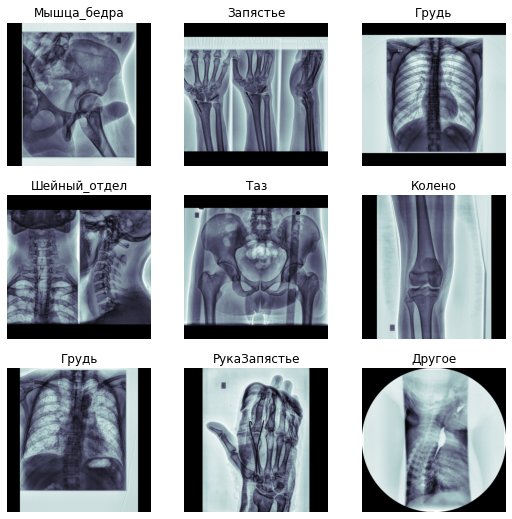

In [16]:
dls = db.dataloaders(train_df)
dls.show_batch()


In [17]:
from fastai.metrics import accuracy_multi

В задачах, которые на первый взгляд совершенно разные (классификация по одной метке, классификация по нескольким меткам и регрессия), в итоге мы используем одну и ту же модель с разным количеством выходов. Функция потерь - это единственное, что меняется, поэтому важно дважды проверить, что вы используете правильную функцию потерь для вашей задачи.

fastai автоматически попытается выбрать правильную из данных, которые вы построили, но если вы используете чистый PyTorch для построения DataLoaders, убедитесь, что вы хорошо подумали, когда вам придется принимать решение о выборе функции потерь, и помните, что вы, скорее всего, хотите:

nn.CrossEntropyLoss для классификации с одной меткой

nn.BCEWithLogitsLoss   или ASL Loss  для классификации по нескольким меткам

nn.MSELossдля регрессии



In [18]:
#ASL Loss
# DATA
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

  
 # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.mean()
    
    
@delegates()
class AsymmetricLossFlat(BaseLoss):
    @use_kwargs_dict(keep=True, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8)
    def __init__(self, *args,  axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(AsymmetricLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)
    

In [19]:
dls = db.dataloaders(train_df, bs=2)

In [46]:
dls.train_ds

(#1391) [(PILImage mode=RGB size=512x512, TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])),(PILImage mode=RGB size=512x512, TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])),(PILImage mode=RGB size=512x512, TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])),(PILImage mode=RGB size=512x512, TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])),(PILImage mode=RGB size=512x512, TensorMultiCat

In [47]:
dls.valid_ds

(#347) [(PILImage mode=RGB size=512x512, TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])),(PILImage mode=RGB size=512x512, TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])),(PILImage mode=RGB size=512x512, TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])),(PILImage mode=RGB size=512x512, TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])),(PILImage mode=RGB size=512x512, TensorMultiCate

In [28]:
learn = vision_learner(
    dls, 
    densenet121, 
    loss_func=AsymmetricLossFlat(),
    metrics=[accuracy_multi,]
).to_fp16()

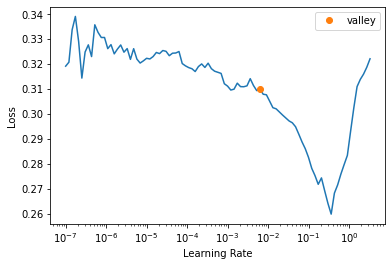

In [21]:
lr = learn.lr_find()
#Решение о том, как изменять наши параметры в зависимости от значений градиентов.является важной частью процесса глубокого обучения. 
#Почти все подходы начинаются с базовой идеи умножения градиента на некоторое небольшое число, называемое скоростью обучения (LR). 
#Часто скорость обучения - это число от 0,001 до 0,1, хотя она может быть любой.
#Если выбрать слишком низкую скорость обучения, это может привести к необходимости выполнения большого количества шагов.
#Но выбор слишком высокой скорости обучения еще хуже - он может привести к увеличению потерь.
#Cyclical Learning Rates for Training Neural Networks,Leslie N. Smith,2015 .

In [22]:
learn.fine_tune(5,lr[0]).to_fp16

epoch,train_loss,valid_loss,accuracy_multi,precision_score,time
0,0.055498,0.030778,0.956210,0.117789,09:45


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy_multi,precision_score,time
0,0.050300,0.042755,0.913826,0.046645,02:06
1,0.038310,0.020982,0.943558,0.061042,02:06
2,0.027605,0.038807,0.934983,0.035943,02:06
3,0.022201,0.014695,0.953328,0.082741,02:06
4,0.020534,0.016022,0.945245,0.044498,02:07


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

AttributeError: ignored

In [23]:
learn.save('stage-1.Multilabel_accuracy')

Path('models/stage-1.Multilabel_accuracy.pth')

In [24]:
learn.unfreeze()


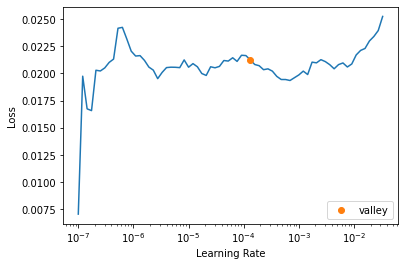

In [27]:
lr = learn.lr_find()

In [29]:
%%time
learn.fit_one_cycle(30, lr[0])

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.301853,0.193352,0.507415,01:41
1,0.303360,0.185943,0.520068,01:43
2,0.278413,0.148810,0.550011,01:40
3,0.248160,0.134405,0.569832,01:40
4,0.205306,0.093358,0.631405,01:40
5,0.137413,0.047753,0.765727,01:39
6,0.082489,0.036471,0.824770,01:40
7,0.055789,0.019492,0.934069,01:43
8,0.038989,0.016124,0.946229,01:43
9,0.038046,0.014749,0.955086,01:43


CPU times: user 47min 52s, sys: 43.5 s, total: 48min 35s
Wall time: 50min 10s


In [31]:
learn.save('/content/drive/MyDrive/models/stage-2.Multilabel_accuracy')

Path('/content/drive/MyDrive/models/stage-2.Multilabel_accuracy.pth')

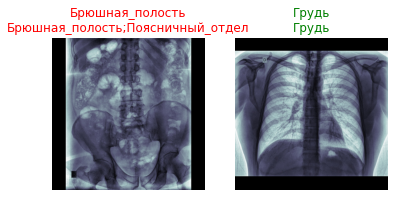

In [43]:
learn.show_results()#(max_n=4,figsize=(7,8))


In [48]:
p, t = learn.get_preds(0)

In [49]:
p = p.numpy()
t = t.numpy()

In [52]:
img_lst = learn.dls.train_ds.items['SOPInstanceUID'].to_list()

In [53]:
np.save('/content/drive/MyDrive/models/imgs.npy', img_lst)
np.save('/content/drive/MyDrive/models//probs.npy', p)